<a href="https://colab.research.google.com/github/fortworthjack/NotebooksFromColab/blob/main/Model_Ensemble_Percentile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ensemble Model Data Image Creater
V1.0 - Steven Fleegel (steven.fleegel@noaa.gov)

This script works with the GEFS/EC-Ensemble Data and can plot 30/50-panels or single panel images of percentile or prob of exceedance calculations.

**Data Availability:** <br>
GEFS: 1/1/2017 to Present <br>
EC-EPS: 1/18/2023 to Present

## **Run this to download, install, and import the appropriate packages.**  
This first cell will take around a minute to run and get everything ready for us to download the data and make the image(s).

In [ ]:
# @title
# Install the packages needed for this notebook.
!pip install -q cartopy contextily pyproj pyepsg xesmf netCDF4 herbie-data metpy eccodes --progress-bar off

## Imports
from herbie import Herbie
from herbie import FastHerbie
#from toolbox import EasyMap, pc
#from paint.standard2 import cm_tmp
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.colors
from matplotlib import ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
from copy import deepcopy
#import xoak

from metpy.cbook import get_test_data
#from metpy.plots import add_metpy_logo
import metpy.plots
from metpy.plots import ctables
import metpy.calc as mpcalc
#from metpy.units import units
# Import for plotting High/Low
from scipy.ndimage import maximum_filter, minimum_filter

print ("Install & Import Done!")

  Preparing metadata (setup.py) ... done
 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ INFO: Created a default config file.                 │
 │ You may view/edit Herbie's configuration here:       │
 │          /root/.config/herbie/config.toml            │
 ╰──────────────────────────────────────────────────────╯



/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Install & Import Done!


##**Download Data and Prep for image creation**

Because this is downloading all of the ensemble members, this may take some time to complete (GEFS takes 5-10 min for 72hr Accumulations, but individual hours are much faster).  As long as you are not changing the valid times or Accumumlation Period, you will be able to create different images with selections in the next section below.

In [ ]:
#### GEFS Info #####
#The GEFS model product could be any of the following:
#- 'atmos.5' - Half degree atmos PRIMARY fields (pgrb2ap5); ~83 most common variables.
#- 'atmos.5b' - Half degree atmos SECONDARY fields (pgrb2bp5); ~500 least common variables
#- 'atmos.25' - Quarter degree atmos PRIMARY fields (pgrb2sp25); ~35 most common variables
#- 'wave' - Global wave products. - 'chem.5' - Chemistry fields on 0.5 degree grid
#- 'chem.25' - Chemistry fields on 0.25 degree grid
#
#ou also must specify a member.
#For the atmos output, this should be something like:
# 0 or "c00" for control member,
# 1-30 or "p01"-"p30" for members 1-30,
# or 'avg' or 'mean' for the ensemble mean,
# or 'spr' for ensemble spread.

# Base Variables
Map_Type_Single = False
IncludeCounties = False
tick_bins = None
Add_Sfc_Contours = False

# Google Colab Selections
#@markdown # **Initial Forecast Info**
#@markdown <b>Select Model - ifs = EC-EPS</b>
Model = "ifs" #@param ['gefs','ifs']
#@markdown <b>Select Model Run</b>
Model_Date = "2024-03-22" #@param {type:"date"}
Model_Run = 12 #@param {type:"slider", min:0, max:18, step:6}
Model_Run=str(Model_Run).zfill(2)+":00"
dtg = Model_Date+" "+Model_Run

#@markdown <b>Select Forecast Valid Time</b><br />
Forecast_Date = "2024-03-26" #@param {type:"date"}
Forecast_Time = 12 #@param {type:"slider", min:0, max:23, step:1}
Forecast_Time=str(Forecast_Time)+":00"
Forecast_Valid_Time = Forecast_Date+" "+Forecast_Time

# Parse strings into datetime objects
time1 = datetime.strptime(dtg, "%Y-%m-%d %H:%M")
time2 = datetime.strptime(Forecast_Valid_Time, "%Y-%m-%d %H:%M")
# Calculate time difference
time_difference = time2 - time1
# Convert time difference to hours
fhr = int(time_difference.total_seconds() / 3600)
##@markdown <b>Select forecast hour</b><br />
#fhr = 96 #@param {type:"slider", min:0, max:360, step:6}
step = np.arange(0, 73, 1, dtype=int)
dt = str.split(Model_Date,'-')

#@markdown # **Model Data**
#@markdown <b>Select Model Data</b>
Map_Data = "QPF" #@param ["QPF","Temp", "SnowDepth"]
#@markdown Note: Snow Depth is only available for the GEFS.
#@markdown If you selected "Temp", what level do you want?<br />
Temp_Level = "850" #@param ["925","850", "700"]
#@markdown If you selected "QPF", what accumulation period do you want?<br />
Accum_Period = "24" #@param ["6","12","24", "36", "48", "72", "RunTotal","None"]

#@markdown # **Map: Area and Type**
#@markdown <b>Select Map Info - Zoom</b>
Map_Zoom = "SD" #@param ["ABR", "SD", "MN", "Dakotas", "Hawaii", "AR", "CONUS", "NA", "SPC_13", "SPC_15", "SPC_18", "GulfMex", "Custom"]
#@markdown ### If a Custom domain is selected, adjust the items below<br>
#@markdown Enter a custom name if you want (mainly used for filename)
custom_name = "FSD" #@param {type:"string"}
#@markdown Enter custom lat/lon bounding box if custom was selected
custom_bottom_lat =  42.2 #@param {type:"number"}
custom_left_lon = -101.32 #@param {type:"number"}
custom_top_lat = 45.32 #@param {type:"number"}
custom_right_lon = -94.97 #@param {type:"number"}

# Model Info.
if Model == "gefs":
  if Map_Data == "Wind Gust":
    Model_Product = 'atmos.5b'
  else:
    Model_Product = 'atmos.5' #'atmos.25'
  Model_Members = 30
if Model == "ifs":
  Model_Product = 'enfo'
  Model_Members = 50

## Define Map Extents
if Map_Zoom == "ABR":
    #ABR
    Map_Extent = [-102.32, -95.97, 43.2, 46.32]
elif Map_Zoom == "SD":
    #SD
    Map_Extent = [-104.5, -95.85, 42.3, 46.4]
elif Map_Zoom == "Dakotas":
    #Dakotas
    Map_Extent = [-104.5, -95.85, 42.3, 49.27]
elif Map_Zoom == "MN":
    #CONUS
    Map_Extent = [-97.8, -89.1, 43.2, 49.7]
elif Map_Zoom == "CONUS":
    #CONUS
    Map_Extent = [-125, -65, 18, 58]
elif Map_Zoom == "NA":
    #North America
    Map_Extent = [-156, -46, 10, 67]
elif Map_Zoom == "Hawaii":
    #Hawaii
    Map_Extent = [-160.5, -154, 18, 23]
elif Map_Zoom == "SPC_13":
    #SPC MesoA Zoom 13
    Map_Extent = [-109.28846, -86.61031, 38.20657, 50]
elif Map_Zoom == "SPC_15":
    #SPC MesoA Zoom 15
    Map_Extent = [-108.85, -86.395, 25.52, 38.494]
elif Map_Zoom == "SPC_18":
    #SPC MesoA Zoom 18
    Map_Extent = [-96.58446, -76.61933, 23.15515, 37.45531]
elif Map_Zoom == "AR":
    #CONUS
    Map_Extent = [-95.5, -89.395, 32.75, 37.23]
elif Map_Zoom == "GulfMex":
    #Gulf of Mexico
    Map_Extent = [-101, -77, 16.5, 32]
elif Map_Zoom == "Custom":
    # Custom
    Map_Extent = [custom_left_lon, custom_right_lon, custom_bottom_lat, custom_top_lat]

# Set Projection
# Make the Central Lat/Lon in the middle of the map
cent_lon = ((Map_Extent[0] - Map_Extent[1])/2) + Map_Extent[1]
cent_lat = ((Map_Extent[3] - Map_Extent[2])/2) + Map_Extent[2]
# Assign projection
#crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
crs = ccrs.LambertConformal(central_longitude=cent_lon, central_latitude=cent_lat)

# Download data via Herbie
### GRIB Info: https://www.nco.ncep.noaa.gov/pmb/products/gens/gep01.t00z.pgrb2a.0p50.f003.shtml
#data = H.xarray(":APCP:")
#data['tp'] = data.tp * 0.0393701
#H = Herbie(dtg, model=Model, product=Model_Product, member=Model_Members, fxx=fhr)
#data = H.xarray(":APCP:")
#data['tp'] = data.tp * 0.0393701
#data = data.rename({'tp': 'p01'})
if Model == "gefs":
  if Map_Data == "Wind Gust":
    search_param = ":GUST:"
  elif Map_Data == "Temp":
    search_param = "TMP:"+ Temp_Level + " mb"
  elif Map_Data == "SnowDepth":
    search_param = ":SNOD:"
  else:
    search_param = ":APCP:"
if Model == "ifs":
  if Map_Data == "Temp":
    search_param = ":t:"+ Temp_Level
  else:
    search_param = ":tp:"

if Model == "gefs":
  for x in range(1, Model_Members+1):
    data_variable = "p"+str(x).zfill(2)
    print("Downloading GEFS member: ", data_variable)
    if Map_Data == "QPF" and Accum_Period != "RunTotal" and Accum_Period != "None":
      fcstdl = range((fhr-int(Accum_Period)+6), fhr+1, 6)
    else:
      fcstdl = [fhr]
    DATES = pd.date_range(
        start=dtg,
        periods=1,
        freq="1h",
    )
    FH = FastHerbie(DATES, model=Model, product=Model_Product, member=data_variable, fxx=fcstdl, remove_grib=False) #, remove_grib=False
    if x == 1:
      data = FH.xarray(search_param)
      if Map_Data == "QPF":
        data[data_variable] = data.tp * 0.0393701
        data = data.drop_vars(['tp'])
      elif Map_Data == "SnowDepth":
        data[data_variable] = data.sde * 39.3701#0.0393701
        data = data.drop_vars(['sde'])
      else:
        data[data_variable] = data.t - 273.15 #Convert to C
        data = data.drop_vars(['t'])
    else:
      datatemp = FH.xarray(search_param)
      if Map_Data == "QPF":
        data[data_variable] = datatemp.tp * 0.0393701
      elif Map_Data == "SnowDepth":
        data[data_variable] = datatemp.sde * 39.3701 #0.0393701
      else:
        data[data_variable] = datatemp.t - 273.15 #Convert to C
      del datatemp
    if Map_Data == "QPF":
      if Accum_Period != "6":
        data = data.sum(dim='step')
#    H = Herbie(dtg, model=Model, product=Model_Product, member=data_variable, fxx=fhr)
#    if x == 1:
#      data = H.xarray(search_param)
#      data[data_variable] = data.tp * 0.0393701
#      data = data.drop_vars(['tp'])
#    else:
#      datatemp = H.xarray(search_param)
#      data[data_variable] = datatemp.tp * 0.0393701
#      del datatemp
else:
  H = Herbie(dtg, model=Model, product=Model_Product, fxx=fhr, remove_grib=False)
  data_per1 = H.xarray(search_param)
  if Map_Data == "QPF" and Accum_Period != "RunTotal" and Accum_Period != "None":
    # Since ECMWF provides total precip, need to grab previous to get 6hr data
    # Grab 3hrs before, if within 144hrs
    #if fhr < 145:
    #  H1 = Herbie(dtg, model=Model, product=Model_Product, fxx=fhr-3)
    #  data_per2 = H1.xarray(search_param)
    #else:
    H1 = Herbie(dtg, model=Model, product=Model_Product, fxx=fhr-int(Accum_Period), remove_grib=False)
    data_per2 = H1.xarray(search_param)
    #testdata = data[0] - data1[0]
    data = data_per1[0].tp - data_per2[0].tp
    data = data * 0.0393701 * 1000
  else:
    #data = data_per1[0].tp - data_per2[0].tp
    if Map_Data == "QPF":
      data = data_per1[0].tp * 0.0393701 * 1000
    elif Map_Data == "SnowDepth":
      data = data_per1[0].tp * 39.3701 #0.0393701
    else:
      data = data_per1[0].t - 273.15 # Convert to C

#if Map_Type == "Sfc Wind Gust":
#  data = H.xarray("GUST")
#  data['gust'] = data.gust.metpy.convert_units('mph')
#  max_type = 'gust'


padding = 1.5 # padding around domain

# Clip Model Data to save processing/mapping time
# Clip 1D Lat/Lon
if Model == "gefs":
  final_data = data.sel(latitude=slice((Map_Extent[3]+padding),(Map_Extent[2]-padding)), longitude=slice((Map_Extent[0]+360.-padding),(Map_Extent[1]+360.+padding)))
else:
  final_data = data.sel(latitude=slice((Map_Extent[3]+padding),(Map_Extent[2]-padding)), longitude=slice((Map_Extent[0]-padding),(Map_Extent[1]+padding)))
  # Needed for Original - Single file data??? below
  #final_data = data[0].sel(latitude=slice((Map_Extent[3]+padding),(Map_Extent[2]-padding)), longitude=slice((Map_Extent[0]-padding),(Map_Extent[1]+padding)))

# Get Max Values
#if max_type != None:
#  max_value = final_data.get(max_type).max()#.max_type.values

#Remove extra variable
if Model == "gefs":
  final_data = final_data.drop_vars("gribfile_projection")


✅ Found ┊ model=ifs ┊ product=enfo ┊ 2024-Mar-22 12:00 UTC F96 ┊ GRIB2 @ azure ┊ IDX @ azure
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.
✅ Found ┊ model=ifs ┊ product=enfo ┊ 2024-Mar-22 12:00 UTC F72 ┊ GRIB2 @ azure ┊ IDX @ azure
Note: Returning a list of [2] xarray.Datasets because cfgrib opened with multiple hypercubes.


# **Create Image**

This section will create the image based on the data selections.  Remember, if you want to change the Map_Type (i.e. QPF to Snow Depth), you'll need to download the data above. Otherwise, you can change selections and rerun this section of code as much as you want.

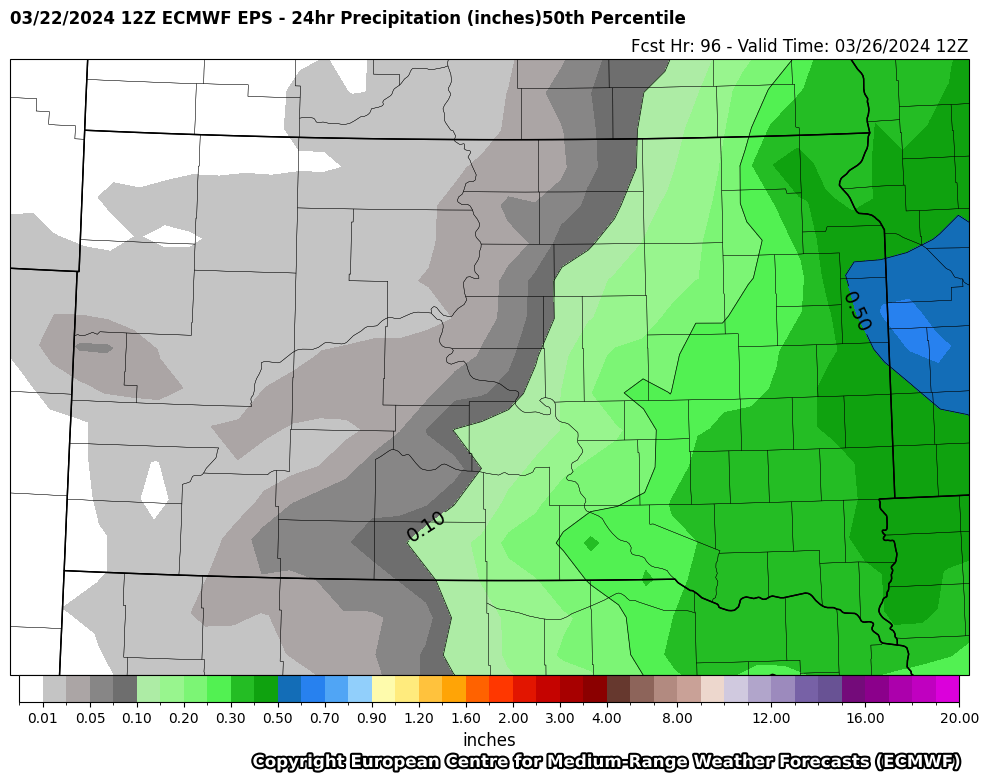

In [ ]:
# Set Variables
Map_Type_Single = False

#Default Map Size
Map_Fig_Size = (13, 8)

#@markdown # **Individual Map Type Selections**
#@markdown ## What type of graphic do you want to create?
Map_Type = "Percentile" #@param ["All_Members", "ProbExceed", "Percentile", "Percentile-6Panel"]

#@markdown ## <br>ProbExceed Map - Select Probability of Exceedance
#@markdown ### Select QPF Probability of Exceedance
qpf_poe = 0.5 #@param {type:"slider", min:0, max:3, step:0.01}
#@markdown ### Select Temp Probability of Exceedance
Temp_poe = -15 #@param {type:"slider", min:-30, max:30, step:1}
#@markdown ### Select Snow Depth Probability of Exceedance
SD_poe = 6 #@param {type:"slider", min:0, max:36, step:1}
#@markdown ## <br>Single Percentile Map - Select Percentile
Pctl_Single = 50 #@param {type:"slider", min:0, max:100, step:1}
#@markdown ## <br> Percenitle 6-Panel Map - Select Percentiles
Pctl_UL = 10 #@param {type:"slider", min:0, max:100, step:1}
Pctl_UM = 25 #@param {type:"slider", min:0, max:100, step:1}
Pctl_UR = 50 #@param {type:"slider", min:0, max:100, step:1}
Pctl_LL = 75 #@param {type:"slider", min:0, max:100, step:1}
Pctl_LM = 90 #@param {type:"slider", min:0, max:100, step:1}
Pctl_LR = 95 #@param {type:"slider", min:0, max:100, step:1}

#@markdown # **Custom Map Adjustments**

# @markdown ###If needed, adjust for map panel spacing
# @markdown ##### Adjust the height and width dimensions of the figure. - May require some testing
# @markdown For a traditional landscape rectangle, these values should get you close:
# @markdown <ol><li>All_Members: <ol><li>GEFS: Height = 13, Width = 20</li><li>ECMWF-Ens: Height = 11, Width = 28</li></ol>
# @markdown <li>ProbExceed: Height = 9, Width = 13</li>
# @markdown <li>Percentile: Height = 9, Width = 13</li>
# @markdown <li>Percentile-6Panel: Height = 8, Width = 13</li>
fig_height = 11 # @param {type:"raw"}
fig_height = int(fig_height)
fig_width = 28 # @param {type:"raw"}
fig_width = int(fig_width)

## Redefine Map Info for Changing QPF items
## Define Map Extents
if Map_Zoom == "ABR":
    #ABR
    IncludeCounties = True
elif Map_Zoom == "SD":
    #SD
    if Map_Type == "All_Members":
      if Model == "ifs":
        Map_Fig_Size = (28, 11)
      else:
        Map_Fig_Size = (20, 13)
    IncludeCounties = True
elif Map_Zoom == "Dakotas":
    #Dakotas
    if Map_Type == "All_Members":
      if Model == "ifs":
        Map_Fig_Size = (16, 10)
      else:
        Map_Fig_Size = (14, 14.5)
    elif Map_Type == "Percentile-6Panel":
      Map_Fig_Size = (14,12)
    else:
      Map_Fig_Size = (14,16)
    IncludeCounties = True
elif Map_Zoom == "MN":
    #CONUS
    Map_Fig_Size = (14,16)
    IncludeCounties = True
elif Map_Zoom == "CONUS":
    #CONUS
    Map_Fig_Size = (14, 14)
#elif Map_Zoom == "NA":
#    #North America
elif Map_Zoom == "Hawaii":
    #Hawaii
    IncludeCounties = True
elif Map_Zoom == "SPC_13":
    #SPC MesoA Zoom 13
    if Map_Type == "All_Members":
      if Model == "ifs":
        Map_Fig_Size = (28, 11)
      else:
        Map_Fig_Size = (20, 11)
    else:
      Map_Fig_Size = (14, 11)
    IncludeCounties = True
elif Map_Zoom == "SPC_15":
    #SPC MesoA Zoom 15
    IncludeCounties = True
elif Map_Zoom == "SPC_18":
    #SPC MesoA Zoom 18
    IncludeCounties = True
    Map_Fig_Size = (16,14)
elif Map_Zoom == "AR":
    #CONUS
    #Map_Fig_Size = (17,16)
    IncludeCounties = True
#elif Map_Zoom == "GulfMex":
    #Gulf of Mexico
    #Map_Fig_Size = (16,14)
elif Map_Zoom == "Custom":
    # Custom
    Map_Fig_Size = (fig_width, fig_height)
    IncludeCounties = True

# Function used to create the map subplots
def plot_background(ax):
    ax.set_extent(Map_Extent)
    if IncludeCounties:
      ## Get data to plot state and county boundaries, roads
      counties = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_2_counties',
            scale='10m',
            facecolor='none')
      ax.add_feature(counties,edgecolor='grey',linewidth=0.25) #, zorder=3.4)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

# Data Projection
map_crs = ccrs.PlateCarree()

# Set projection of map display
# This significantly increases run time. - Would need to change this line: ax = plt.subplot(projection=mapproj)
mapproj = ccrs.LambertConformal(central_longitude=cent_lon, central_latitude=cent_lat)

# Valid Time
# Create a clean datetime object for plotting based on time of Geopotential heights
if Model == "gefs":
  ### Previous version before moving to FastHerbie
  #vtime = datetime.strptime(str(final_data.valid_time.data.astype('datetime64[ms]')),
  #                        '%Y-%m-%dT%H:%M:%S.%f')
  # Convert the string to a datetime object
  vtime = datetime.strptime(dtg, '%Y-%m-%d %H:%M')
  # Add 120 hours to the datetime
  vtime += timedelta(hours=fhr)
  #vtime_txt = "TEST"
else:
  vtime = datetime.strptime(str(data_per1[0].valid_time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')
#COMMENTED THIS OUT BELOW FOR TESTING
vtime_txt = vtime.strftime("%m/%d/%Y %HZ")
# Model Time
# Create a clean datetime object for plotting based on time of Geopotential heights
model_time = datetime.strptime(str(final_data.time.data.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')
model_time_txt = model_time.strftime("%m/%d/%Y %HZ")

#### Figure Creation ####
# Create the figure and plot background on different axes
if Map_Type == "All_Members":
  if Model == "gefs":
    fig, axarr = plt.subplots(nrows=5, ncols=6, figsize=Map_Fig_Size, constrained_layout=True,
                            subplot_kw={'projection': mapproj})
  else:
    fig, axarr = plt.subplots(nrows=5, ncols=10, figsize=Map_Fig_Size, constrained_layout=True,
                            subplot_kw={'projection': mapproj})
elif Map_Type == "Percentile-6Panel":
  fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=Map_Fig_Size, constrained_layout=True,
                            subplot_kw={'projection': mapproj})
else:
  fig = plt.figure(figsize=Map_Fig_Size)
  #ax = plt.axes(projection=mapproj)
  ax = plt.subplot(projection=mapproj)
  ax.set_extent(Map_Extent)

#Accum_Period
# Map info for Single Panel Plots
if Map_Type == "ProbExceed" or Map_Type == "Percentile":
  if IncludeCounties:
    ## Get data to plot state and county boundaries, roads
    counties = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_2_counties',
        scale='10m',
        facecolor='none')
    ax.add_feature(counties,edgecolor='black',linewidth=0.25) #, zorder=3.4)
  ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
  ax.add_feature(cfeature.STATES, linewidth=1)
  ax.add_feature(cfeature.BORDERS, linewidth=2)

#Run Total Accum
if Map_Data == "QPF" and Map_Type != "ProbExceed":
  if Map_Type == "Percentile":
    Map_Type_Single = True
  #Data_Values = final_data.p01
  if Accum_Period == "RunTotal":
    Panel_1_range = [0.00, 0.01, 0.10, 0.25, 0.5, 1.0, 1.5, 2., 3., 4.,
         6., 8., 10., 15., 20., 30., 50.]
    if Map_Type == "Percentile-6Panel":
      Tick_range = [0.00, 0.01, 0.25, 1.0, 2., 4.,
          8., 15., 30., 50.]
    else:
      Tick_range = [0.00, 0.01, 0.10, 0.25, 0.5, 1.0, 1.5, 2., 3., 4.,
          6., 8., 10., 15., 20., 30., 50.]
    if Model == "ifs":
      panel_title_text = ' EPS - Run Total Precipitation (inches) '
    else:
      panel_title_text = ' Run Total Precipitation (inches) '
    #NWS QPF Colortable
    colors = ["#FFFFFF", "#c7e9c0", "#a1d99b", "#74c477", "#31a353", "#006d2c", "#fff98a", "#ffcd4f",
            "#fe8d3c", "#fc4d2a", "#d61a1d", "#ad0025",
            "#700025", "#3b0030", "#3b0030", "#4d0073", "#ffdbff"]
  else:
    Panel_1_range = [0.00, 0.01, 0.03, 0.05, 0.075, 0.10, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5,
                   0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 3.5, 4,
                   6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    if Map_Type == "Percentile-6Panel":
      Tick_range = [0.01, 0.10, 0.5, 1.0, 2, 5,
                   10, 20]
    else:
      Tick_range = [0.01, 0.05, 0.10, 0.2, 0.3, 0.5,
                   0.7, 0.9, 1.2, 1.6, 2, 3, 4,
                   8, 12, 16, 20]
    if Model == "ifs":
      panel_title_text = ' EPS - '+str(Accum_Period)+'hr Precipitation (inches)'
    else:
      panel_title_text = ' '+str(Accum_Period)+'hr Precipitation (inches)'
    #WxBell Colortable
    colors = ["#FFFFFF", "#BFBFBF", "#ABA5A5", "#838383", "#6E6E6E", "#B5FBAB", "#97F58D",
            "#78F572", "#50F150", "#1EB51E", "#0EA10E", "#1464D3", "#2883F1", "#50A5F5",
            "#97D3FB", "#FFFBAB", "#FFE978", "#FFC13C", "#FFA100", "#FF6000", "#FF3200",
            "#E11400", "#C10000", "#A50000", "#870000", "#643C32", "#8D645A", "#B58D83",
            "#C9A197", "#F1DDD3", "#CFC9DF", "#ADA1C9", "#9B89BD", "#725CA3", "#685293",
            "#760076", "#8C008C", "#B100B1", "#C100C1", "#DB00DB", ]
  if Map_Type == "Percentile" or Map_Type == "Percentile-6Panel":
    panel_title_text = panel_title_text + str(Pctl_Single) + 'th Percentile'
  # Needed to help make sure the colortable works with low level ramp up.
  colornorm = matplotlib.colors.BoundaryNorm(boundaries=Panel_1_range, ncolors=256)
  map_label = 'inches'
  max_label = 'Max Accum QPF: \n'
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=256)

if Map_Data == "QPF" and Map_Type == "ProbExceed":
  Map_Type_Single = True
  if Accum_Period == "RunTotal":
    Map_Duration = 'Run Total'
  else:
    Map_Duration = str(Accum_Period)+'hr'
  panel_title_text = ' '+Map_Duration+' Probability of Exceeding '+str(qpf_poe)+'\" QPF'
  map_label = '%'
  # Set range of contourf mapping.
  Panel_1_range = np.arange(5, 101, 5)
  norm = matplotlib.colors.Normalize(0,1)
  ProbRaincolors = [[norm( 0.0), "#FFFFFF"],
                [norm( 0.04), "#FFFFFF"],
                [norm( 0.05), "#F5FBF2"],
                [norm( 0.25), "#C7E5BD"],
                [norm( 0.5), "#7FBD79"],
                [norm( 0.75), "#408347"],
                [norm( 1.0), "#1E4B23"]]
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", ProbRaincolors, N=100)
  #Calculate the Prob of Exceedance
  if Model == "gefs":
    Data_Values = (final_data > qpf_poe).to_array().sum(axis=0)
    Data_Values = (Data_Values / 30)*100
  else:
    Data_Values = (final_data > qpf_poe).sum(dim='number')
    Data_Values = (Data_Values / 50)*100
    #### Orig for Total Accum
    #Data_Values = (final_data > ((qpf_poe/1000)/0.0393701)).to_array().sum(dim='number')
    #Data_Values = (Data_Values[0] / 50)*100

if Map_Data == "Temp" and Map_Type != "ProbExceed":
  if Map_Type == "Percentile":
    Map_Type_Single = True
  if Model == "ifs":
    panel_title_text = ' EPS - ' + Temp_Level + 'mb Temp '
  else:
    panel_title_text = ' - ' + Temp_Level + 'mb Temp '
  if Map_Type == "Percentile" or Map_Type == "Percentile-6Panel":
    panel_title_text = panel_title_text + str(Pctl_Single) + 'th Percentile'
  #Sfc Temp Colortable - WeatherBell
  Panel_1_range = np.arange(-50, 41, 1)
  Tick_range = [-50, -40, -30, -20, -10, 0,
                   10, 20, 30, 40]
  norm = matplotlib.colors.Normalize(0,1)
  colors = [[norm( 0.0), "#3f0390"],
                [norm( 0.074), "#bc0482"],
                [norm( 0.139), "#fa4da4"],
                [norm( 0.204), "#dca9d3"],
                [norm( 0.296), "#92f2f0"],
                [norm( 0.365), "#11504e"],
                [norm( 0.43), "#d2d2d2"],
                [norm( 0.435), "#341e9d"],
                [norm( 0.504), "#aa2c2c"],
                [norm( 0.574), "#f7e7e7"],
                [norm( 0.596), "#a1dfeb"],
                [norm( 0.648), "#555590"],
                [norm( 0.696), "#ffff78"],
                [norm( 0.8), "#780000"],
                [norm( 0.817), "#632720"],
                [norm( 0.861), "#bca79e"],
                [norm( 0.943), "#722944"],
                [norm( 1.0), "#008c40"]]
  #N_Number = 90
  # Frequency of labels on colorbar - Tick marks
  #tick_bins = 23
  # Needed to help make sure the colortable works with low level ramp up.
  colornorm = matplotlib.colors.BoundaryNorm(boundaries=Panel_1_range, ncolors=256)
  map_label = 'deg C'
  max_label = Temp_Level + 'mb Temp: \n'
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=256)

if Map_Data == "Temp" and Map_Type == "ProbExceed":
  Map_Type_Single = True
  if Model == "ifs":
    panel_title_text = ' EPS - Probability of ' + Temp_Level + 'mb Temperature >= '+str(Temp_poe)+' deg C'
  else:
    panel_title_text = ' Probability of ' + Temp_Level + 'mb Temperature >= '+str(Temp_poe)+' deg C'
  map_label = '%'
  # Set range of contourf mapping.
  Panel_1_range = np.arange(5, 101, 5)
  norm = matplotlib.colors.Normalize(0,1)
  ProbRaincolors = [[norm( 0.0), "#FFFFFF"],
                [norm( 0.04), "#FFFFFF"],
                [norm( 0.05), "#F5FBF2"],
                [norm( 0.25), "#C7E5BD"],
                [norm( 0.5), "#7FBD79"],
                [norm( 0.75), "#408347"],
                [norm( 1.0), "#1E4B23"]]
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", ProbRaincolors, N=100)
  #Calculate the Prob of Exceedance
  if Model == "gefs":
    Data_Values = (final_data >= Temp_poe).to_array().sum(axis=0)
    Data_Values = (Data_Values / 30)*100
  else:
    Data_Values = (final_data >= Temp_poe).sum(dim='number')
    Data_Values = (Data_Values / 50)*100
    #### Orig for Total Accum
    #Data_Values = (final_data > ((qpf_poe/1000)/0.0393701)).to_array().sum(dim='number')
    #Data_Values = (Data_Values[0] / 50)*100

if Map_Data == "SnowDepth" and Map_Type != "ProbExceed":
  if Map_Type == "Percentile":
    Map_Type_Single = True
  if Model == "ifs":
    panel_title_text = ' EPS - Snow Depth (inches)'
  else:
    panel_title_text = ' - Snow Depth (inches)'
  if Map_Type == "Percentile" or Map_Type == "Percentile-6Panel":
    panel_title_text = panel_title_text + str(Pctl_Single) + 'th Percentile'
  #Sfc Temp Colortable - WeatherBell
  #Panel_1_range = np.arange(-50, 41, 1)
  Panel_1_range = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 18,
         24, 36]
  if Map_Type == "Percentile-6Panel":
    Tick_range = [0, 0.1, 0.5, 1, 2, 4, 6, 8, 12, 18, 36]
  else:
    Tick_range = [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 18,
         24, 36]
  #norm = matplotlib.colors.Normalize(0,1)
  #N_Number = 90
  #NWS QPF Colortable
  colors = ["#FFFFFF", "#BDD7E6", "#94C3DE", "#6BAFD6", "#3282BD", "#08519D", "#083C99", "#082694", "#FFFF9B",
            "#FFE14E", "#FFC300", "#FFA500",
            "#FE8700", "#EC4E00", "#DA1400", "#9D0000", "#690000",]
  #cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=17)
  extend_val = 'neither'
  # Frequency of labels on colorbar - Tick marks
  #tick_bins = 23
  # Needed to help make sure the colortable works with low level ramp up.
  colornorm = matplotlib.colors.BoundaryNorm(boundaries=Panel_1_range, ncolors=17)#256
  map_label = 'inches'
  max_label = 'Snow Depth: \n'
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=17)#256

if Map_Data == "SnowDepth" and Map_Type == "ProbExceed":
  Map_Type_Single = True
  panel_title_text = ' Probability of Snow Depth >= '+str(SD_poe)+' in'
  map_label = '%'
  # Set range of contourf mapping.
  Panel_1_range = np.arange(5, 101, 5)
  norm = matplotlib.colors.Normalize(0,1)
  ProbRaincolors = [[norm( 0.0), "#FFFFFF"],
                [norm( 0.04), "#FFFFFF"],
                [norm( 0.05), "#F5FBF2"],
                [norm( 0.25), "#C7E5BD"],
                [norm( 0.5), "#7FBD79"],
                [norm( 0.75), "#408347"],
                [norm( 1.0), "#1E4B23"]]
  cmap_1D = matplotlib.colors.LinearSegmentedColormap.from_list("", ProbRaincolors, N=100)
  #Calculate the Prob of Exceedance
  if Model == "gefs":
    Data_Values = (final_data >= SD_poe).to_array().sum(axis=0)
    Data_Values = (Data_Values / 30)*100
  else:
    Data_Values = (final_data >= SD_poe).sum(dim='number')
    Data_Values = (Data_Values / 50)
    #### Orig for Total Accum
    #Data_Values = (final_data > ((qpf_poe/1000)/0.0393701)).to_array().sum(dim='number')
    #Data_Values = (Data_Values[0] / 50)*100

### Create Contours for Pctl-6P maps
# Get the Pctnl Data
if Map_Type == "Percentile-6Panel":
  Add_Sfc_Contours = True
  if Model == 'gefs':
    Data_Values_UL = np.percentile(final_data.to_array(), Pctl_UL, axis=0)
    Data_Values_UM = np.percentile(final_data.to_array(), Pctl_UM, axis=0)
    Data_Values_UR = np.percentile(final_data.to_array(), Pctl_UR, axis=0)
    Data_Values_LL = np.percentile(final_data.to_array(), Pctl_LL, axis=0)
    Data_Values_LM = np.percentile(final_data.to_array(), Pctl_LM, axis=0)
    Data_Values_LR = np.percentile(final_data.to_array(), Pctl_LR, axis=0)
  else:
    Data_Values_UL = np.percentile(final_data, Pctl_UL, axis=0)
    Data_Values_UM = np.percentile(final_data, Pctl_UM, axis=0)
    Data_Values_UR = np.percentile(final_data, Pctl_UR, axis=0)
    Data_Values_LL = np.percentile(final_data, Pctl_LL, axis=0)
    Data_Values_LM = np.percentile(final_data, Pctl_LM, axis=0)
    Data_Values_LR = np.percentile(final_data, Pctl_LR, axis=0)
elif Map_Type == "Percentile":
  Add_Sfc_Contours = True
  if Model == 'gefs':
    Data_Values = np.percentile(final_data.to_array(), Pctl_Single, axis=0)
  else:
    Data_Values = np.percentile(final_data, Pctl_Single, axis=0)

# 30-50 Panel Plot
if Map_Type == "All_Members":
  axlist = axarr.flatten()
  for ax in axlist:
    plot_background(ax)
  if Model == "gefs":
    for p in range(1,31):
      Model_P = "p"+str(p).zfill(2)
      #print (Model_P)
      cf1 = axlist[p-1].contourf(final_data.longitude, final_data.latitude, final_data.get(str(Model_P)), Panel_1_range, norm=colornorm,
                                 cmap=cmap_1D, transform=map_crs)
      # Preset Ticks due to low level ramp up.
      #cb1 = fig.colorbar(cf1, ax=ax, ticks=Panel_1_range, orientation='horizontal', shrink=0.74, aspect= 35, pad=0)
      # Add Pert # in map
      #axlist[p-1].text(.01, .99, Model_P, ha='left', va='top', transform=ax.transAxes)
      axlist[p-1].annotate(Model_P, (0,0), (2, 8), xycoords='axes points', textcoords='offset points', va='top', ha="left",
             fontweight='bold', fontsize=9, color='black',)
  else:
    for p in range(1,51):
      #Model_P = "p"+str(p).zfill(2)
      #print (Model_P)
      cf1 = axlist[p-1].contourf(final_data.longitude, final_data.latitude, final_data[p-1], Panel_1_range, norm=colornorm, cmap=cmap_1D,
                                 transform=map_crs)
      #cf1 = axlist[p-1].contourf(final_data.longitude, final_data.latitude, final_data[p], cmap=plt.cm.hsv, transform=map_crs)
      # Preset Ticks due to low level ramp up.
      #cb1 = fig.colorbar(cf1, ax=ax, ticks=Panel_1_range, orientation='horizontal', shrink=0.74, aspect= 35, pad=0)
      # Add Pert # in map
      #axlist[p-1].text(.01, .99, Model_P, ha='left', va='top', transform=ax.transAxes)
      #axlist[p-1].set_label(p-1)
      axlist[p-1].annotate(p, (0,0), (2, 8), xycoords='axes points', textcoords='offset points', va='top', ha="left",
             fontweight='bold', fontsize=9, color='black',)
elif Map_Type == "Percentile-6Panel":
  axlist = axarr.flatten()
  for ax in axlist:
    plot_background(ax)
  # Upper left plot - ProbSnow UL
  cf1 = axlist[0].contourf(final_data.longitude, final_data.latitude, Data_Values_UL, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
  #axlist[0].clabel(cf1, fontsize=16, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
  cb1 = fig.colorbar(cf1, ax=axlist[0], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  cb1.set_label(map_label, size='large')

  # Upper middle plot - ProbSnow UM

  cf2 = axlist[1].contourf(final_data.longitude, final_data.latitude, Data_Values_UM, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
  cb2 = fig.colorbar(cf2, ax=axlist[1], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  cb2.set_label(map_label, size='large')

  # Upper right plot - ProbSnow UR

  cf3 = axlist[2].contourf(final_data.longitude, final_data.latitude, Data_Values_UR, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                          transform=map_crs)
  cb3 = fig.colorbar(cf3, ax=axlist[2], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  cb3.set_label(map_label, size='large')

  # Lower left plot - ProbSnow LL
  cf4 = axlist[3].contourf(final_data.longitude, final_data.latitude, Data_Values_LL, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                           transform=map_crs)
  cb4 = fig.colorbar(cf4, ax=axlist[3], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  cb4.set_label(map_label, size='large')

  # Lower middle plot - ProbSnow LM
  cf5 = axlist[4].contourf(final_data.longitude, final_data.latitude, Data_Values_LM, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                           transform=map_crs)
  cb5 = fig.colorbar(cf5, ax=axlist[4], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  cb5.set_label(map_label, size='large')

  #### Lower left plot - ProbSnow

  cf6 = axlist[5].contourf(final_data.longitude, final_data.latitude, Data_Values_LR, Panel_1_range, norm=colornorm, cmap=cmap_1D,
                           transform=map_crs)
  cb6 = fig.colorbar(cf6, ax=axlist[5], ticks=Tick_range, orientation='horizontal', shrink=0.9, pad=0)
  cb6.set_label(map_label, size='large')

  if Add_Sfc_Contours:
    # Contour Range and Formatting
    if Map_Data == "QPF":
      contourrange = [0.1, 0.25, 0.5, 1, 2, 3, 4]
      contour_fmt = '%.2f'
    elif Map_Data == "Temp":
      contourrange = np.arange(-50, 40, 5)
      contour_fmt = '%.0f'
    elif Map_Data == "SnowDepth":
      contourrange = np.arange(0, 60, 2)
      contour_fmt = '%.0f'
    ## UL
    cf1c = axlist[0].contour(final_data.longitude, final_data.latitude, Data_Values_UL, levels=contourrange, colors='black',
                          linewidths=0.5, linestyles='solid', transform=map_crs)
    cf1cl = axlist[0].clabel(cf1c, fontsize=14, inline=1, inline_spacing=1, fmt=contour_fmt, rightside_up=True)
    ## UM
    cf2c = axlist[1].contour(final_data.longitude, final_data.latitude, Data_Values_UM, levels=contourrange, colors='black',
                          linewidths=0.5, linestyles='solid', transform=map_crs)
    cf2cl = axlist[1].clabel(cf2c, fontsize=14, inline=1, inline_spacing=1, fmt=contour_fmt, rightside_up=True)
    ## UR
    cf3c = axlist[2].contour(final_data.longitude, final_data.latitude, Data_Values_UR, levels=contourrange, colors='black',
                          linewidths=0.5, linestyles='solid', transform=map_crs)
    cf3cl = axlist[2].clabel(cf3c, fontsize=14, inline=1, inline_spacing=1, fmt=contour_fmt, rightside_up=True)
    ## LL
    cf4c = axlist[3].contour(final_data.longitude, final_data.latitude, Data_Values_LL, levels=contourrange, colors='black',
                          linewidths=0.5, linestyles='solid', transform=map_crs)
    cf4cl = axlist[3].clabel(cf4c, fontsize=14, inline=1, inline_spacing=1, fmt=contour_fmt, rightside_up=True)
    ## LM
    cf5c = axlist[4].contour(final_data.longitude, final_data.latitude, Data_Values_LM, levels=contourrange, colors='black',
                          linewidths=0.5, linestyles='solid', transform=map_crs)
    cf5cl = axlist[4].clabel(cf5c, fontsize=14, inline=1, inline_spacing=1, fmt=contour_fmt, rightside_up=True)
    ## LR
    cf6c = axlist[5].contour(final_data.longitude, final_data.latitude, Data_Values_LR, levels=contourrange, colors='black',
                          linewidths=0.5, linestyles='solid', transform=map_crs)
    cf6cl = axlist[5].clabel(cf6c, fontsize=14, inline=1, inline_spacing=1, fmt=contour_fmt, rightside_up=True)
else:
  # Single Panel Plot
  if Map_Type == "Percentile":
    cf1 = ax.contourf(final_data.longitude, final_data.latitude, Data_Values, Panel_1_range, norm=colornorm, cmap=cmap_1D, transform=map_crs, zorder=1) #cmap_1D
    # Preset Ticks due to low level ramp up.
    cb1 = fig.colorbar(cf1, ax=ax, ticks=Tick_range, orientation='horizontal', shrink=0.74, aspect= 35, pad=0)
    if Add_Sfc_Contours:
      # Contour Range and Formatting
      if Map_Data == "QPF":
        contourrange = [0.1, 0.25, 0.5, 1, 2, 3, 4]
        contour_fmt = '%.2f'
      elif Map_Data == "Temp":
        contourrange = np.arange(-50, 40, 5)
        contour_fmt = '%.0f'
      elif Map_Data == "SnowDepth":
        contourrange = np.arange(0, 60, 2)
        contour_fmt = '%.0f'
      ## UL
      cf1c = ax.contour(final_data.longitude, final_data.latitude, Data_Values, levels=contourrange, colors='black',
                          linewidths=0.5, linestyles='solid', transform=map_crs)
      cf1cl = ax.clabel(cf1c, fontsize=14, inline=1, inline_spacing=1, fmt=contour_fmt, rightside_up=True)
  else:
    # Contour Range and Formatting
    contourrange = np.arange(0, 101, 10)
    contour_fmt = '%.0f'
    ## Add Contours and Text Label
    cf1c = ax.contour(final_data.longitude, final_data.latitude, Data_Values, levels=contourrange, colors='black',
                        linewidths=0.5, linestyles='solid', transform=map_crs)
    cf1cl = ax.clabel(cf1c, fontsize=14, inline=1, inline_spacing=1, fmt=contour_fmt, rightside_up=True)
    ## Add ProbExceedance data
    cf1 = ax.contourf(final_data.longitude, final_data.latitude, Data_Values, Panel_1_range, cmap='jet', transform=map_crs, zorder=1) #cmap_1D
    # Preset Ticks due to low level ramp up.
    cb1 = fig.colorbar(cf1, ax=ax, ticks=Panel_1_range, orientation='horizontal', shrink=0.74, aspect= 35, pad=0)

# Add Colorbar for Multiple Subplots
if Map_Type == "All_Members":
  #cb1 = fig.colorbar(cf1, ax=axarr.ravel().tolist(), ticks=Panel_1_range, orientation='horizontal', shrink=0.74, aspect= 35, pad=0)
  cb1 = fig.colorbar(cf1, ax=axarr, ticks=Tick_range, orientation='horizontal', shrink=0.54, aspect= 45, pad=0)

# Add Colorbar Tick Bins
if tick_bins != None:
  # Adjust Tick Marks on Colorbar
  tick_locator = ticker.MaxNLocator(nbins=tick_bins)
  cb1.locator = tick_locator
  cb1.update_ticks()
cb1.set_label(map_label, size='large')

if Model == 'ifs':
  Model_Name = 'ec-eps'
else:
  Model_Name = Model
# Add panel title
if Map_Type == "All_Members":
  #fig.suptitle(model_time_txt + ' ' + Model.upper() + panel_title_text)
  Model_Title_Left = model_time_txt + ' ' + Model_Name.upper() + panel_title_text
  fig.text(0.01, 0.99, Model_Title_Left, transform=fig.transFigure, horizontalalignment='left', fontweight='bold', fontsize='14')
  #fig.suptitle('Fcst Hr: ' + str(fhr) + ' - Valid Time: {}'.format(vtime_txt), loc='right')
  Model_Title_Right = 'Fcst Hr: ' + str(fhr) + ' - Valid Time: {}'.format(vtime_txt)
  fig.text(0.99, 0.99, Model_Title_Right, transform=fig.transFigure, horizontalalignment='right', fontweight='bold', fontsize='14')
elif Map_Type == "Percentile-6Panel":
  if Map_Data == "QPF":
    Base_Panel_Text = ' - ' + Map_Duration + ' QPF '
  elif Map_Data == "Temp":
    Base_Panel_Text = ' - ' + Temp_Level + 'mb ' + Map_Data + ' '
  elif Map_Data == "SnowDepth":
    Base_Panel_Text = ' - Snow Depth '
  # Loop to add each panel title
  Pctl_Text_UL = Base_Panel_Text + str(Pctl_UL) + 'th Pctl'
  Pctl_Text_UM = Base_Panel_Text + str(Pctl_UM) + 'th Pctl'
  Pctl_Text_UR = Base_Panel_Text + str(Pctl_UR) + 'th Pctl'
  Pctl_Text_LL = Base_Panel_Text + str(Pctl_LL) + 'th Pctl'
  Pctl_Text_LM = Base_Panel_Text + str(Pctl_LM) + 'th Pctl'
  Pctl_Text_LR = Base_Panel_Text + str(Pctl_LR) + 'th Pctl'
  panel_title_text = [Pctl_Text_UL, Pctl_Text_UM, Pctl_Text_UR, Pctl_Text_LL, Pctl_Text_LM, Pctl_Text_LR]
  #Set title second row location
  title_y_adjust = 1.055
  for i in range(0,6):
    axlist[i].set_title(model_time_txt + ' ' + Model_Name.upper() + panel_title_text[i], loc='left', fontweight='bold', fontsize=12, y=title_y_adjust)
    axlist[i].set_title('\nFcst Hr: ' + str(fhr) + ' - Valid: {}'.format(vtime_txt), loc='right')
else:
  ax.set_title(model_time_txt + ' ' + Model_Name.upper() + panel_title_text, loc='left', fontweight='bold', fontsize='12', y=1.045)
  ax.set_title('\nFcst Hr: ' + str(fhr) + ' - Valid Time: {}'.format(vtime_txt), loc='right', fontsize='12')

# Set height padding for plots
#fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)

# Set figure title
#fig.suptitle(str(model_time) + " " + mdl.upper() + " Analysis - " + final_data['time'].dt.strftime('%d %B %Y %H:%MZ').values + ' Forecast Hour: ' + str(fhr), fontsize=24)

# Add Credits
if Model == "ifs":
  if Map_Type_Single:
    plt.figtext(0.99, -0.15, 'Copyright European Centre for Medium-Range Weather Forecasts (ECMWF)', horizontalalignment='right',
                fontweight='bold', fontsize=12, color='white', transform=ax.transAxes,
                path_effects=[pe.withStroke(linewidth=3, foreground="black")])
  elif Map_Type == "Percentile-6Panel":
    plt.figtext(0.99, -0.03, 'Copyright European Centre for Medium-Range Weather Forecasts (ECMWF)', horizontalalignment='right',
                fontweight='bold', fontsize=10, color='white',
                path_effects=[pe.withStroke(linewidth=3, foreground="black")])
  else:
    plt.figtext(0.99, -0.03, 'Copyright European Centre for Medium-Range Weather Forecasts (ECMWF)', horizontalalignment='right',
                fontweight='bold', fontsize=12, color='white',
                path_effects=[pe.withStroke(linewidth=3, foreground="black")])

# Tighten up the plot
if Map_Type != "All_Members" and Map_Type != "Percentile-6Panel":
  #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.tight_layout()

## Save Image

#Set domain name for the image name.
if Map_Zoom == "Custom" and custom_name != "":
  domain_name = custom_name
else:
  domain_name = Map_Zoom
# Preset Image Name
Img_Name_Pre = Model_Name + "_" + domain_name + "_" + Map_Data + "_" + Map_Type
if Map_Type == "All_Members":
  Img_Name_Type = "_" + str(Accum_Period) + "hrAccum_Run-"
elif Map_Type == "ProbExceed":
  if Map_Data == "QPF":
    Img_POE = qpf_poe
  elif Map_Data == "Temp":
    Img_POE = Temp_poe
  elif Map_Data == "SnowDepth":
    Img_POE = SD_poe
  Img_Name_Type = "Prob" + str(Img_POE).replace(".", "_") + "_" + str(Accum_Period) + "hrAccum_Run-"
elif Map_Type == "Percentile":
  Img_Name_Type = "_" + str(Pctl_Single) + "Pctl_" + str(Accum_Period) + "hrAccum_Run-"
elif Map_Type == "Percentile-6Panel":
  Img_Name_Type = "Pctl_" + str(Accum_Period) + "hrAccum_Run-"
Img_Name = Img_Name_Pre + Img_Name_Type + Model_Date + "_" + str(Model_Run)[:-3] + "Z_F" + str(fhr) + ".png"
plt.savefig(f"{Img_Name}", dpi = 150, facecolor='w')#, bbox_inches = "tight")

# Display the plot
plt.show()